In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D, SeparableConv2D, AveragePooling2D
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow import concat
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

In [2]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"

#ds_file = "synthethic_holograms_ft_ac_complex_v0.nc"
#data_rescale = 255  # set to 1 or 255 depending on input file
#channel_name = "complex"

#ds_file = "synthethic_holograms_ft_ac_complex_amp_phase_v0.nc" # amplitude and phase
#data_rescale = 1  # set to 1 or 255 depending on input file
#channel_name = "complex"

#ds_file = "synthethic_holograms_v0_ft_ac_real_imag_amplitude.nc"  # real, imaginary, amplitude
#data_rescale = 1  # set to 1 or 255 depending on input file
#channel_name = "channels"

ds_file = "synthethic_holograms_ft_ac_v0.nc"  # amplitude only
data_rescale = 255
channel_name = None

ds = xr.open_dataset(ds_path+ds_file)  # file with mean (DC) value removed

In [3]:
split_index = 7000  # number of training+validation points
valid_index = 2000  # number of validation points
all_labels = ds[["d"]].to_dataframe()
train_labels = all_labels.iloc[valid_index:split_index]
test_labels = all_labels.iloc[split_index:]
val_labels = all_labels.iloc[:valid_index]
scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_val_labels = pd.DataFrame(scaler.fit_transform(val_labels), index=val_labels.index, columns=val_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

In [4]:
if channel_name is None:
    in_data = ds["image_ft"].transpose("hologram_number", "ysize", 'xsize').expand_dims("channel", 3)
else:
    in_data = ds["image_ft"].transpose("hologram_number", "ysize", "xsize",channel_name)

In [5]:
scaled_in_data = in_data / data_rescale

In [13]:
filter_input = Input(shape=in_data.shape[1:])

# use average pooling for input
pool_1 = AveragePooling2D(pool_size=(4, 4))(filter_input)
flat = Flatten()(pool_1)

# skip average pooling
#flat = Flatten()(filter_input)  

dense_1 = Dense(64, activation="relu")(flat)
dense_2 = Dense(32, activation="relu")(dense_1)
dense_3 = Dense(16, activation="relu")(dense_2)
dense_4 = Dense(8, activation="relu")(dense_3)
out = Dense(all_labels.shape[1])(dense_4)  # number of outputs determined by the parameters we are training to
mod = Model(filter_input, out)
mod.compile(optimizer="adam", loss="mae", metrics=['acc'])
mod.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 600, 1)]     0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 100, 150, 1)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                960064    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136 

In [15]:
history = mod.fit(scaled_in_data[valid_index:split_index].values, scaled_train_labels.values, 
                  batch_size=16, epochs=30, verbose=1,
                  validation_data=(scaled_in_data[:valid_index].values,scaled_val_labels.values))

Train on 5000 samples, validate on 2000 samples
Epoch 1/30
5000/5000 [==============================] - 32s 6ms/sample - loss: 0.0617 - acc: 4.0000e-04 - val_loss: 0.0489 - val_acc: 0.0010
Epoch 2/30
5000/5000 [==============================] - 30s 6ms/sample - loss: 0.0343 - acc: 4.0000e-04 - val_loss: 0.0312 - val_acc: 0.0010
Epoch 3/30
5000/5000 [==============================] - 29s 6ms/sample - loss: 0.0311 - acc: 4.0000e-04 - val_loss: 0.0264 - val_acc: 0.0010
Epoch 4/30
5000/5000 [==============================] - 29s 6ms/sample - loss: 0.0277 - acc: 4.0000e-04 - val_loss: 0.0243 - val_acc: 0.0010
Epoch 5/30
5000/5000 [==============================] - 29s 6ms/sample - loss: 0.0255 - acc: 4.0000e-04 - val_loss: 0.0246 - val_acc: 0.0010
Epoch 6/30
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0258 - acc: 4.0000e-04 - val_loss: 0.0235 - val_acc: 0.0010
Epoch 7/30
5000/5000 [==============================] - 28s 6ms/sample - loss: 0.0238 - acc: 4.0000e-04 - 

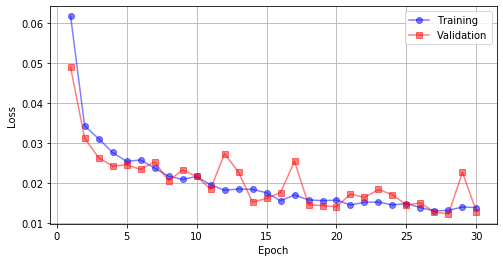

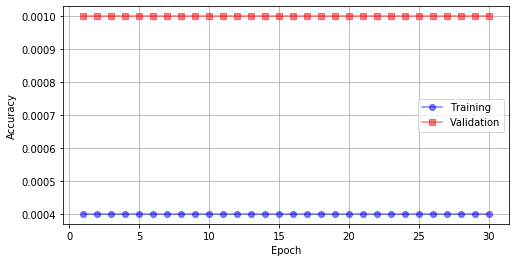

In [21]:
epochs = np.arange(len(history.history['acc']))+1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(epochs,history.history['loss'],'bo-',alpha=0.5,label='Training')
ax.plot(epochs,history.history['val_loss'],'rs-',alpha=0.5,label='Validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(b=True)
plt.legend()
plt.savefig("results/LossHistory_denseNN_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")

fig, bx = plt.subplots(1, 1, figsize=(8, 4))
bx.plot(epochs,history.history['acc'],'bo-',alpha=0.5,label='Training')
bx.plot(epochs,history.history['val_acc'],'rs-',alpha=0.5,label='Validation')
bx.set_xlabel('Epoch')
bx.set_ylabel('Accuracy')
bx.grid(b=True)
plt.legend()
plt.savefig("results/AccuracyHistory_denseNN_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")


In [ ]:
# can skip the training process and just load the CNN model
# mod = load_model("holodec_ft_dxyz_cnn.h5")

In [22]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

10000 samples in 29.588001 seconds
for 0.0029588000999999997 seconds per hologram


In [ ]:
save_model(mod, "results/holodec_"+ds_file.replace(".nc","")+"".join(all_labels.columns)+"_denseNN.h5", save_format="h5")

In [ ]:
preds_original = scaler.inverse_transform(preds_out)

In [ ]:
(test_labels.max() - test_labels.min())

In [ ]:
mean_error = np.mean(preds_original[split_index:] - test_labels.values, axis=0)
std_error = np.std(preds_original[split_index:] - test_labels.values, axis=0)

In [ ]:
validation_data = {}
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.columns):
    ax=axes.ravel()[a]
    ax.scatter(test_labels.iloc[:, a], preds_original[split_index:, a], 1, 'k')
    diag = np.linspace(test_labels.iloc[:, a].min(), test_labels.iloc[:, a].max(), 10)
    ax.plot(diag, diag, 'b--' )
    ax.set_title(test_labels.columns[a])
    plt.text(0.1,0.9,f"${mean_error[a]:.1f} \pm {std_error[a]:.1f} \mu m$",ha='left',va='top',transform=ax.transAxes)
    validation_data[test_labels.columns[a]] = test_labels.iloc[:, a]
    validation_data[test_labels.columns[a]+'_pred'] = preds_original[split_index:, a]
plt.savefig("results/error_scatter_denseNN_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")
validation_data_df = pd.DataFrame(validation_data)
validation_data_df.to_csv('results/validation_data_denseNN_'+ds_file.replace(".nc","_")+''.join(all_labels.columns)+'.txt')
    

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for a, clabel in enumerate(all_labels.columns):
    ax=axes.ravel()[a]
    ax.hist( (preds_original[split_index:, a] - test_labels.iloc[:, a].values) / (test_labels.iloc[:, a].max() - test_labels.iloc[:, a].min()),
           bins=20)
    ax.set_yscale("log")
    ax.set_xlabel("Error in "+test_labels.columns[a])
plt.savefig("results/relative_error_histogram_denseNN_"+ds_file.replace(".nc","_")+"".join(all_labels.columns)+".png", dpi=200, bbox_inches="tight")

In [ ]:
np.mean(np.abs(preds_original[split_index:] - test_labels.values), axis=0)

In [ ]:
np.mean(preds_original[split_index:] - test_labels.values, axis=0)

In [ ]:
np.std(preds_original[split_index:] - test_labels.values, axis=0)

In [ ]:
np.mean(np.abs(preds_out[split_index:] - scaled_test_labels.values), axis=0)

In [ ]:
ds["xsize"]